# Modeling

In [141]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [5]:
# integrating our preprocessing into a pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [10]:
corpus = pd.read_csv('data/spotify-reviews.csv')
corpus = corpus.rename(columns={'review':'tokens'})
spotify_df = pd.read_csv('data/preprocessed-reviews.csv')
#spotify_df = spotify_df.drop(columns=['process_tok'])
data = pd.concat([spotify_df,corpus],axis=1)

In [12]:
spotify_reviews = data[data.sentiment.isin(['pos','neg'])]
spotify_reviews.tokens

0        great music service audio high quality app eas...
1        please ignore previous negative rating app sup...
2        get best spotify experience android annoy plea...
3                       really buggy terrible use recently
4          dear spotify get song put playlist shuffle play
                               ...                        
61589    even communicate lyric feature available user ...
61590    use sooo good back download free version pick ...
61591    app good take device start comp spotify start ...
61592    app good hard navigate let play song click pla...
61593    good sometimes doesnt load music play second s...
Name: tokens, Length: 57573, dtype: object

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

In [14]:
label_enc = LabelEncoder()

In [15]:
X = spotify_reviews.tokens
y = spotify_reviews.sentiment
y = label_enc.fit_transform(y)

In [124]:
spotify_reviews.sentiment.value_counts(normalize=True)

sentiment
pos    0.695899
neg    0.304101
Name: proportion, dtype: float64

In [36]:
np.unique(y, return_counts=True)
# 0 = negative review 
# 1 = positive review

(array([0, 1]), array([17508, 40065], dtype=int64))

In [75]:
class_labels = ['Negative','Positive']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [17]:
pre_process_steps = [('tfdif', TfidfVectorizer())]
preprocess_pipeline = Pipeline(pre_process_steps)
preprocess_pipeline

Pipeline(steps=[('tfdif', TfidfVectorizer())])

In [18]:
X_train_processed = preprocess_pipeline.fit_transform(X_train)

## Creating a Baseline DummyClassifier Model

In [19]:
from sklearn.dummy import DummyClassifier

In [20]:
dummy_clf = DummyClassifier(random_state=42)

In [21]:
dummy_clf.fit(X_train_processed,y_train)

DummyClassifier(random_state=42)

In [22]:
preds = dummy_clf.predict(X_test)

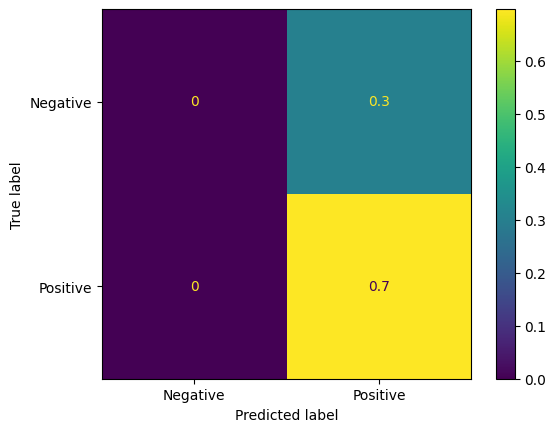

In [120]:
ConfusionMatrixDisplay.from_predictions(y_test,preds, normalize='all',display_labels=['Negative','Positive'])

In [24]:
dummy_clf.score(X_test,y_test)

0.6972556739231126

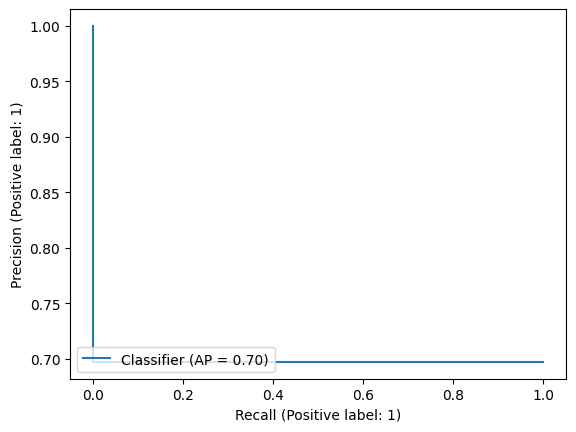

In [25]:
PrecisionRecallDisplay.from_predictions(y_test, preds)

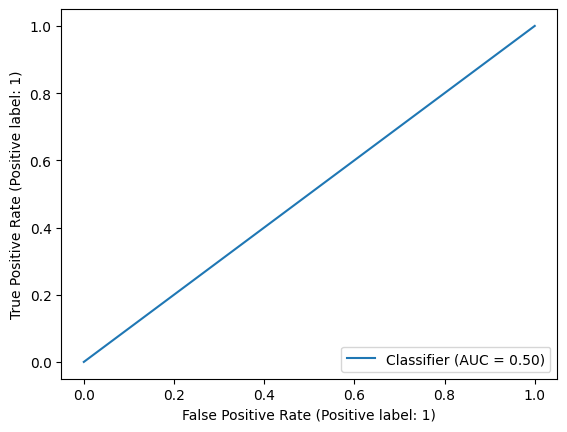

In [26]:
RocCurveDisplay.from_predictions(y_test, preds)

In [118]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5229
           1       0.70      1.00      0.82     12043

    accuracy                           0.70     17272
   macro avg       0.35      0.50      0.41     17272
weighted avg       0.49      0.70      0.57     17272



C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### RandomForestClassifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
rf_clf = RandomForestClassifier(random_state=42)

In [119]:
rf_clf.fit(X_train_processed,y_train)

RandomForestClassifier()

In [30]:
X_test_processed = preprocess_pipeline.transform(X_test)

In [31]:
preds2 = rf_clf.predict(X_test_processed)

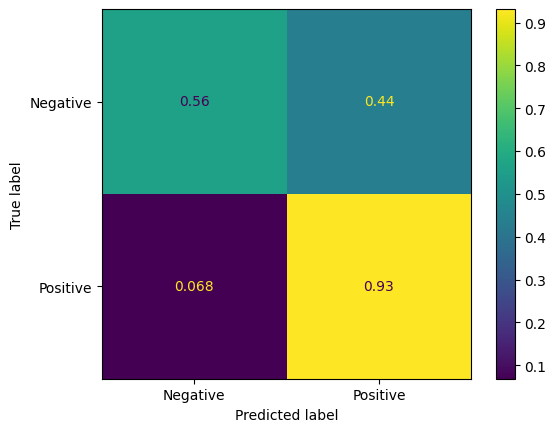

In [76]:
ConfusionMatrixDisplay.from_predictions(y_test, preds2,normalize='true',display_labels=class_labels)

In [139]:
rf_clf.score(X_test_processed,y_test)

0.8164080592867068

In [34]:
print(classification_report(y_test,preds2))

              precision    recall  f1-score   support

           0       0.78      0.56      0.65      5229
           1       0.83      0.93      0.88     12043

    accuracy                           0.82     17272
   macro avg       0.81      0.75      0.77     17272
weighted avg       0.82      0.82      0.81     17272



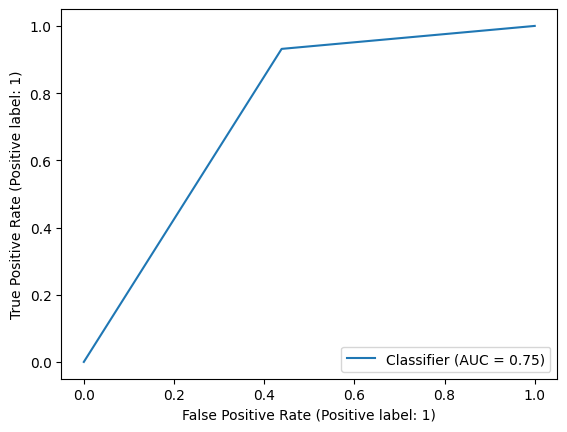

In [37]:
RocCurveDisplay.from_predictionsbz(y_test,preds2)

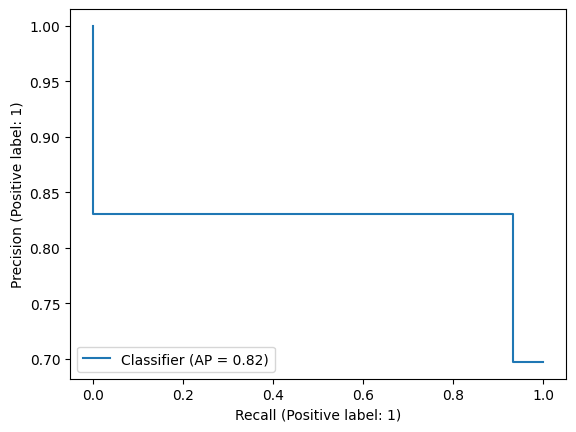

In [38]:
PrecisionRecallDisplay.from_predictions(y_test,preds2)

### Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

In [106]:
log_reg = LogisticRegression(random_state=42)

In [123]:
log_reg.fit(X_train_processed,y_train)

C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [108]:
preds3 = log_reg.predict(X_test_processed)

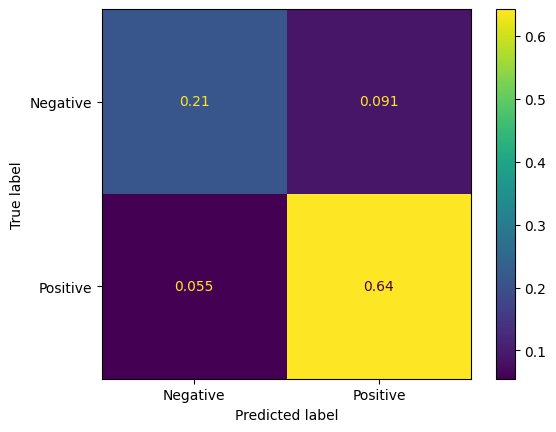

In [122]:
ConfusionMatrixDisplay.from_predictions(y_test, preds3,normalize='all',display_labels=class_labels)

In [110]:
print(classification_report(y_test,preds3))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      5229
           1       0.88      0.92      0.90     12043

    accuracy                           0.85     17272
   macro avg       0.83      0.81      0.82     17272
weighted avg       0.85      0.85      0.85     17272



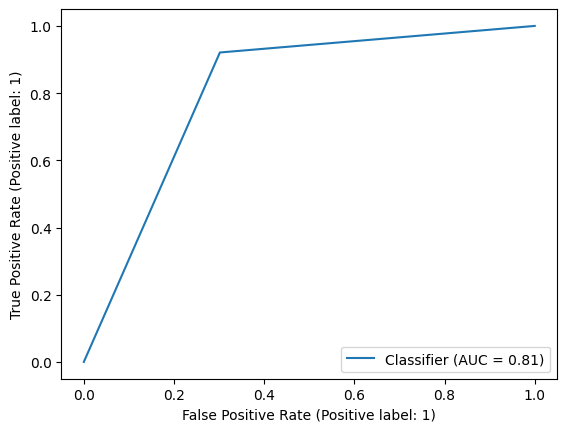

In [111]:
RocCurveDisplay.from_predictions(y_test,preds3)

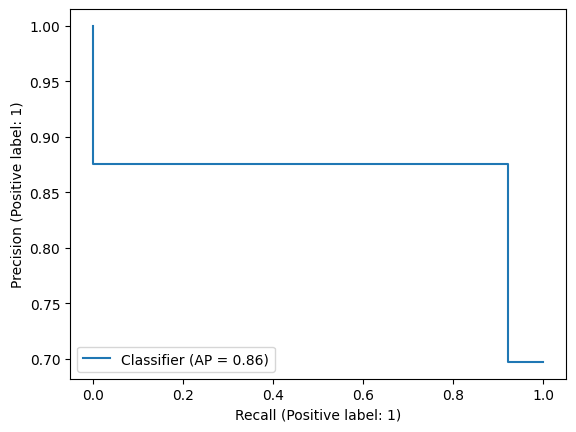

In [112]:
PrecisionRecallDisplay.from_predictions(y_test,preds3)

## Hyperparamter Tuning

### Naive Bayes

In [54]:
from sklearn.naive_bayes import MultinomialNB

In [55]:
multinb = MultinomialNB()

In [56]:
multinb.fit(X_train_processed,y_train)

MultinomialNB()

In [57]:
preds4 = multinb.predict(X_test_processed)

In [58]:
print(classification_report(y_test, preds4))

              precision    recall  f1-score   support

           0       0.78      0.36      0.49      5229
           1       0.77      0.96      0.86     12043

    accuracy                           0.78     17272
   macro avg       0.78      0.66      0.67     17272
weighted avg       0.78      0.78      0.75     17272



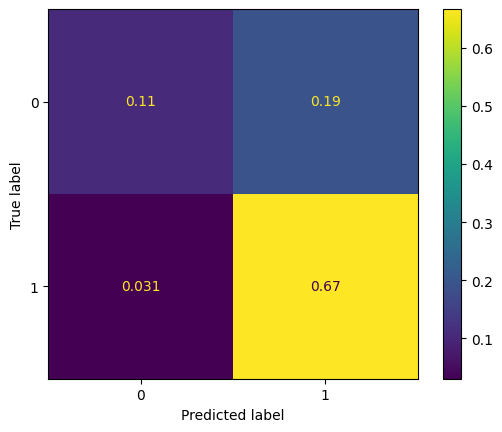

In [61]:
ConfusionMatrixDisplay.from_predictions(y_test, preds4,normalize='all')

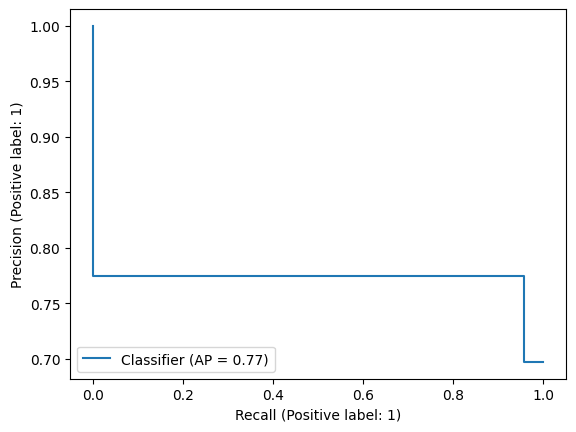

In [127]:
PrecisionRecallDisplay.from_predictions(y_test,preds4)

### Complement Naive Bayes

In [63]:
from sklearn.naive_bayes import ComplementNB

In [64]:
compnb = ComplementNB()

In [65]:
compnb.fit(X_train_processed,y_train)

ComplementNB()

In [66]:
preds5 = compnb.predict(X_test_processed)

In [67]:
print(classification_report(y_test, preds5))

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      5229
           1       0.88      0.81      0.84     12043

    accuracy                           0.79     17272
   macro avg       0.76      0.78      0.77     17272
weighted avg       0.81      0.79      0.80     17272



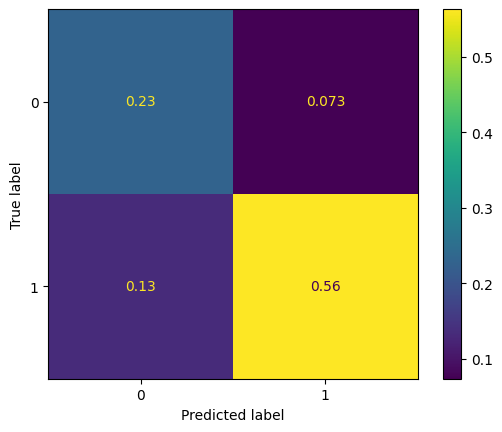

In [68]:
ConfusionMatrixDisplay.from_predictions(y_test, preds5,normalize='all')

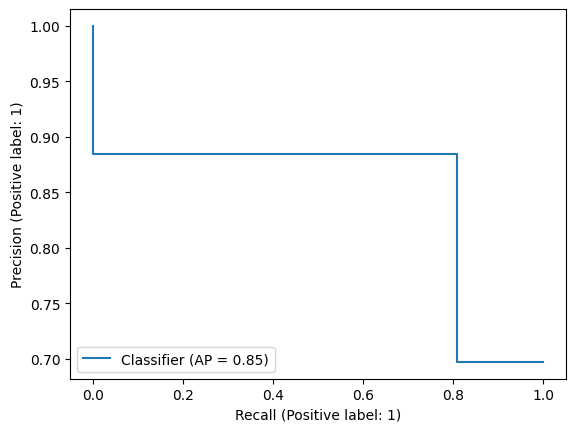

In [125]:
PrecisionRecallDisplay.from_predictions(y_test,preds5)

### XGBoost Model 

In [129]:
from xgboost import XGBClassifier

In [130]:
xgbModel = XGBClassifier(random_state=42)

In [131]:
xgbModel.fit(X_train_processed,y_train)
preds6 = xgbModel.predict(X_test_processed)

In [132]:
print(classification_report(y_test, preds6))

              precision    recall  f1-score   support

           0       0.78      0.64      0.71      5229
           1       0.86      0.92      0.89     12043

    accuracy                           0.84     17272
   macro avg       0.82      0.78      0.80     17272
weighted avg       0.83      0.84      0.83     17272



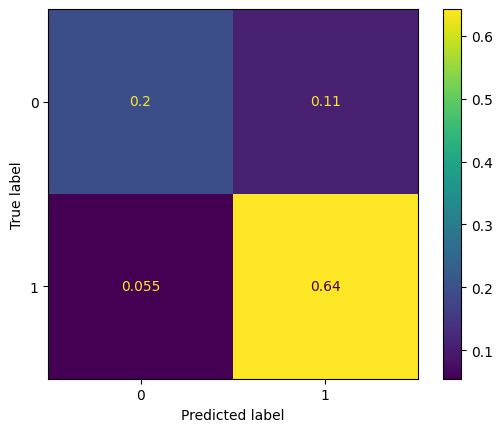

In [134]:
ConfusionMatrixDisplay.from_predictions(y_test, preds6,normalize='all')

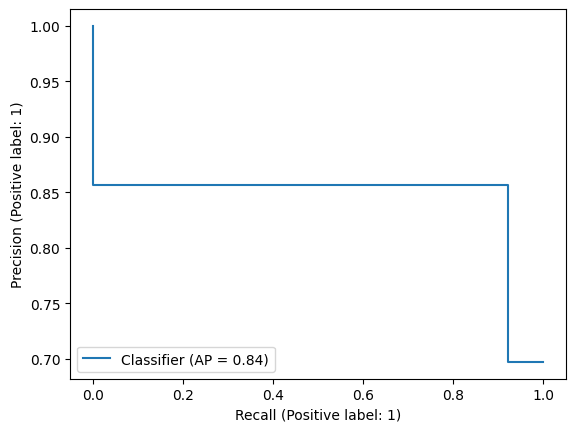

In [136]:
PrecisionRecallDisplay.from_predictions(y_test,preds6)